# Interpreting Integer Solutions: Reading and Validating Discrete Recommendations

This notebook demonstrates how to **interpret integer solutions** correctly. Integer solutions look different from continuous solutions and require different interpretation skills.

Understanding integer solution interpretation is critical because:
- **Integer solutions are whole numbers, not fractions**
- **You cannot fine-tune them the way you can fine-tune continuous solutions**
- **They represent discrete choices, not smooth adjustments**
- **Misinterpreting them leads to implementation errors**


## Key Concepts

**Integer Solutions**:
- Whole numbers: 3 people, 4 machines, 2 locations
- NOT fractional values: 3.7 people, 4.2 machines, 2.3 locations
- Represent discrete choices, not smooth adjustments

**Reading Integer Solutions**:
- When you see "hire 4 people," this means exactly 4, not 3.9 or 4.1
- You cannot adjust by small amounts
- You must work with the discrete options provided

**Common Pitfall**: 
- Continuous models sometimes produce near-integer solutions (e.g., 3.98 people)
- Rounding these can break constraints and create infeasible solutions
- Always model integer decisions as integers from the start

**Critical insight**: Integer solutions are discrete choices. You cannot fine-tune them the way you can fine-tune continuous solutions.


## Scenario: Staffing Decision

You manage a call center and must decide how many staff to hire. The model recommends hiring a specific number of people.

**The Challenge**:
- How do you interpret "hire 4 people"?
- Can you adjust this to 3.9 or 4.1?
- What if the continuous model recommended 3.98 people?
- How do you validate that the integer solution actually works?


## Step 1: Install Packages


In [1]:
%pip install pulp pandas numpy matplotlib



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, value, LpStatus


## Step 3: Define Problem Data


In [3]:
# Problem parameters
cost_per_staff = 50000  # $50,000 per staff member per year
calls_per_staff = 1000  # 1000 calls per staff member per month
min_calls_needed = 3500  # Must handle at least 3500 calls per month
budget = 200000  # Maximum budget: $200,000 per year

print("PROBLEM SETUP:")
print("=" * 60)
print(f"Cost per staff: ${cost_per_staff:,}")
print(f"Calls per staff per month: {calls_per_staff:,}")
print(f"Minimum calls needed per month: {min_calls_needed:,}")
print(f"Budget limit: ${budget:,}")
print("=" * 60)


PROBLEM SETUP:
Cost per staff: $50,000
Calls per staff per month: 1,000
Minimum calls needed per month: 3,500
Budget limit: $200,000


## Step 4: Continuous Model (Produces Near-Integer Solution)

First, let's see what happens when we model this as continuous:


In [4]:
# Continuous model
model_continuous = LpProblem("Staffing_Continuous", LpMinimize)
staff_continuous = LpVariable("staff_continuous", lowBound=0, cat='Continuous')

model_continuous += cost_per_staff * staff_continuous, "Total_Cost"
model_continuous += calls_per_staff * staff_continuous >= min_calls_needed, "Min_Calls"
model_continuous += cost_per_staff * staff_continuous <= budget, "Budget"

model_continuous.solve()

staff_continuous_solution = value(staff_continuous)
total_cost_continuous = value(model_continuous.objective)
calls_handled_continuous = calls_per_staff * staff_continuous_solution

print("CONTINUOUS MODEL SOLUTION:")
print("=" * 60)
print(f"Status: {LpStatus[model_continuous.status]}")
print(f"Staff to hire: {staff_continuous_solution:.2f} people")
print(f"Total cost: ${total_cost_continuous:,.2f}")
print(f"Calls handled: {calls_handled_continuous:,.0f} calls/month")
print("=" * 60)
print("\n⚠️  PROBLEM: You cannot hire 3.50 people!")
print("This is a near-integer solution that needs interpretation.")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/9fd8f4ea72ae4232b76a010da11a3288-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/9fd8f4ea72ae4232b76a010da11a3288-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 11 RHS
At line 14 BOUNDS
At line 15 ENDATA
Problem MODEL has 2 rows, 1 columns and 2 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-2) rows, 0 (-1) columns and 0 (-2) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 175000
After Postsolve, objective 175000, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 175000 - 0 iterations time 0.002, Presolve 0.00
Option for pr

## Step 5: The Rounding Trap

What happens if we round the continuous solution?


In [5]:
# Try rounding down
staff_rounded_down = int(staff_continuous_solution)
cost_rounded_down = cost_per_staff * staff_rounded_down
calls_rounded_down = calls_per_staff * staff_rounded_down

# Try rounding up
staff_rounded_up = int(np.ceil(staff_continuous_solution))
cost_rounded_up = cost_per_staff * staff_rounded_up
calls_rounded_up = calls_per_staff * staff_rounded_up

print("ROUNDING THE CONTINUOUS SOLUTION:")
print("=" * 70)
print(f"{'Option':<20} {'Staff':<10} {'Cost':<15} {'Calls':<15} {'Feasible?'}")
print("-" * 70)
print(f"{'Continuous (exact)':<20} {staff_continuous_solution:<10.2f} ${total_cost_continuous:<14,.0f} {calls_handled_continuous:<15,.0f} ✓")
print(f"{'Round DOWN (3)':<20} {staff_rounded_down:<10} ${cost_rounded_down:<14,.0f} {calls_rounded_down:<15,.0f} {'✗ (too few calls)' if calls_rounded_down < min_calls_needed else '✓'}")
print(f"{'Round UP (4)':<20} {staff_rounded_up:<10} ${cost_rounded_up:<14,.0f} {calls_rounded_up:<15,.0f} {'✗ (over budget)' if cost_rounded_up > budget else '✓'}")
print("=" * 70)

print("\n⚠️  KEY INSIGHT:")
print("Rounding can break constraints!")
print(f"  - Rounding DOWN to {staff_rounded_down} violates minimum calls requirement")
print(f"  - Rounding UP to {staff_rounded_up} might exceed budget")
print("\n✓ SOLUTION: Model as integer from the start!")


ROUNDING THE CONTINUOUS SOLUTION:
Option               Staff      Cost            Calls           Feasible?
----------------------------------------------------------------------
Continuous (exact)   3.50       $175,000        3,500           ✓
Round DOWN (3)       3          $150,000        3,000           ✗ (too few calls)
Round UP (4)         4          $200,000        4,000           ✓

⚠️  KEY INSIGHT:
Rounding can break constraints!
  - Rounding DOWN to 3 violates minimum calls requirement
  - Rounding UP to 4 might exceed budget

✓ SOLUTION: Model as integer from the start!


## Step 6: Integer Model (Correct Approach)

Now let's model this correctly as an integer problem:


In [6]:
# Integer model
model_integer = LpProblem("Staffing_Integer", LpMinimize)
staff_integer = LpVariable("staff_integer", lowBound=0, cat='Integer')

model_integer += cost_per_staff * staff_integer, "Total_Cost"
model_integer += calls_per_staff * staff_integer >= min_calls_needed, "Min_Calls"
model_integer += cost_per_staff * staff_integer <= budget, "Budget"

model_integer.solve()

staff_integer_solution = int(value(staff_integer))
total_cost_integer = value(model_integer.objective)
calls_handled_integer = calls_per_staff * staff_integer_solution

print("INTEGER MODEL SOLUTION:")
print("=" * 60)
print(f"Status: {LpStatus[model_integer.status]}")
print(f"Staff to hire: {staff_integer_solution} people")
print(f"Total cost: ${total_cost_integer:,.2f}")
print(f"Calls handled: {calls_handled_integer:,.0f} calls/month")
print("=" * 60)

print("\n✓ CORRECT INTERPRETATION:")
print(f"  - Hire exactly {staff_integer_solution} people (whole number)")
print(f"  - Cannot adjust to {staff_integer_solution - 1} or {staff_integer_solution + 1} without consequences")
print(f"  - This is a discrete choice, not a smooth value")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/e6f2d044d8d248babd7a70357140c3d3-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/e6f2d044d8d248babd7a70357140c3d3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 13 RHS
At line 16 BOUNDS
At line 18 ENDATA
Problem MODEL has 2 rows, 1 columns and 2 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 175000 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 200000 to -1.79769e+308
Probing was tried 0 times and created 0

## Step 7: Visualizing Integer Solutions as Discrete Points

Let's visualize why integer solutions are discrete choices, not smooth values:


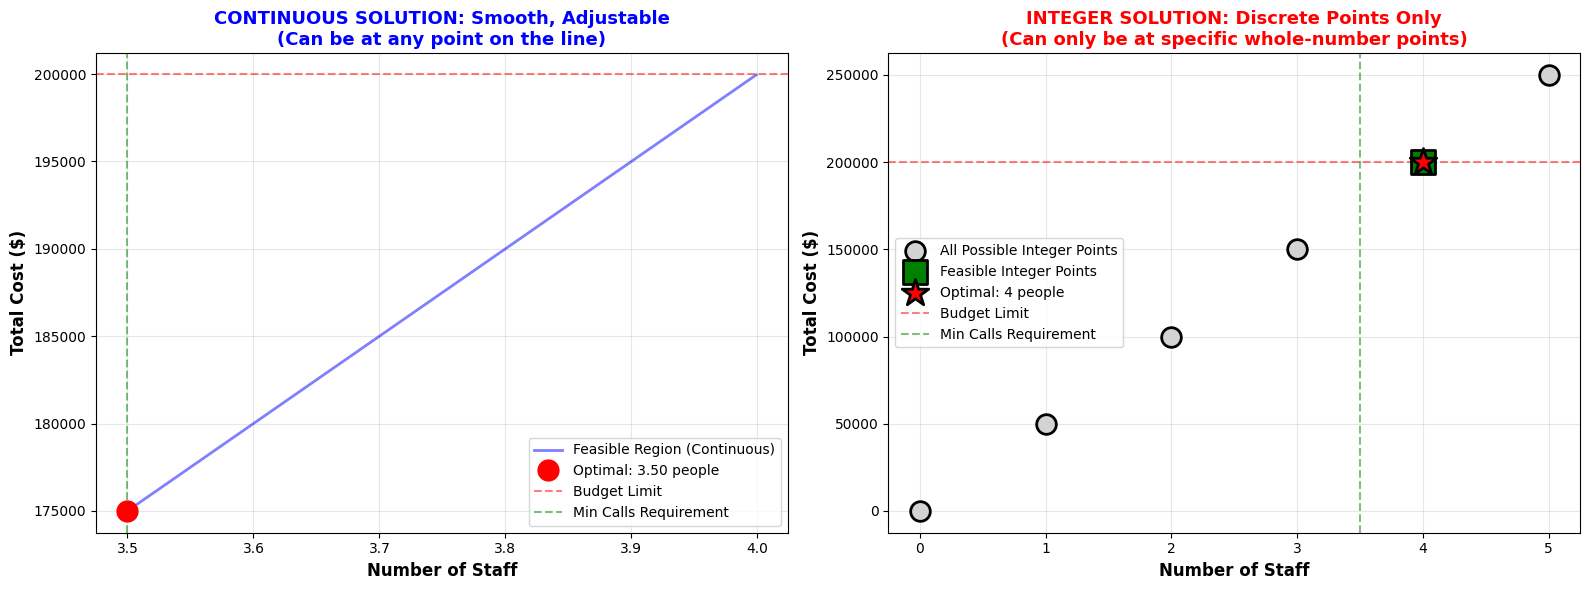


KEY VISUAL DIFFERENCE:
Continuous: Solution can be anywhere on a smooth line
Integer: Solution can ONLY be at specific discrete points
You cannot adjust integer solutions smoothly - you must jump between points!


In [7]:
# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Continuous solution (smooth)
possible_staff_continuous = np.linspace(0, 5, 1000)
possible_costs_continuous = possible_staff_continuous * cost_per_staff
possible_calls_continuous = possible_staff_continuous * calls_per_staff

# Filter feasible region
feasible_mask = (possible_calls_continuous >= min_calls_needed) & (possible_costs_continuous <= budget)
ax1.plot(possible_staff_continuous[feasible_mask], possible_costs_continuous[feasible_mask], 
         'b-', linewidth=2, alpha=0.5, label='Feasible Region (Continuous)')
ax1.plot(staff_continuous_solution, total_cost_continuous, 'ro', markersize=15, 
         label=f'Optimal: {staff_continuous_solution:.2f} people', zorder=3)
ax1.axhline(y=budget, color='r', linestyle='--', alpha=0.5, label='Budget Limit')
ax1.axvline(x=min_calls_needed/calls_per_staff, color='g', linestyle='--', alpha=0.5, label='Min Calls Requirement')
ax1.set_xlabel('Number of Staff', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Cost ($)', fontsize=12, fontweight='bold')
ax1.set_title('CONTINUOUS SOLUTION: Smooth, Adjustable\n(Can be at any point on the line)', 
              fontsize=13, fontweight='bold', color='blue')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# Right plot: Integer solution (discrete points)
possible_staff_integer = np.arange(0, 6)
possible_costs_integer = possible_staff_integer * cost_per_staff
possible_calls_integer = possible_staff_integer * calls_per_staff

# Filter feasible points
feasible_integer_mask = (possible_calls_integer >= min_calls_needed) & (possible_costs_integer <= budget)
feasible_staff = possible_staff_integer[feasible_integer_mask]
feasible_costs = possible_costs_integer[feasible_integer_mask]

ax2.scatter(possible_staff_integer, possible_costs_integer, 
           s=200, color='lightgray', marker='o', edgecolors='black', linewidths=2,
           label='All Possible Integer Points', zorder=2)
ax2.scatter(feasible_staff, feasible_costs, 
           s=300, color='green', marker='s', edgecolors='black', linewidths=2,
           label='Feasible Integer Points', zorder=3)
ax2.scatter([staff_integer_solution], [total_cost_integer], 
           s=400, color='red', marker='*', edgecolors='black', linewidths=2,
           label=f'Optimal: {staff_integer_solution} people', zorder=4)
ax2.axhline(y=budget, color='r', linestyle='--', alpha=0.5, label='Budget Limit')
ax2.axvline(x=min_calls_needed/calls_per_staff, color='g', linestyle='--', alpha=0.5, label='Min Calls Requirement')
ax2.set_xlabel('Number of Staff', fontsize=12, fontweight='bold')
ax2.set_ylabel('Total Cost ($)', fontsize=12, fontweight='bold')
ax2.set_title('INTEGER SOLUTION: Discrete Points Only\n(Can only be at specific whole-number points)', 
              fontsize=13, fontweight='bold', color='red')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)
ax2.set_xticks(possible_staff_integer)

plt.tight_layout()
plt.show()

print("\nKEY VISUAL DIFFERENCE:")
print("=" * 60)
print("Continuous: Solution can be anywhere on a smooth line")
print("Integer: Solution can ONLY be at specific discrete points")
print("You cannot adjust integer solutions smoothly - you must jump between points!")
print("=" * 60)


## Step 8: Validating Integer Solutions

Let's check that the integer solution actually satisfies all constraints:


In [8]:
# Validation checks
validation_results = {
    'Constraint': [],
    'Requirement': [],
    'Actual': [],
    'Status': []
}

# Check minimum calls constraint
validation_results['Constraint'].append('Minimum Calls')
validation_results['Requirement'].append(f'≥ {min_calls_needed:,} calls/month')
validation_results['Actual'].append(f'{calls_handled_integer:,} calls/month')
validation_results['Status'].append('✓ PASS' if calls_handled_integer >= min_calls_needed else '✗ FAIL')

# Check budget constraint
validation_results['Constraint'].append('Budget Limit')
validation_results['Requirement'].append(f'≤ ${budget:,}')
validation_results['Actual'].append(f'${total_cost_integer:,.0f}')
validation_results['Status'].append('✓ PASS' if total_cost_integer <= budget else '✗ FAIL')

# Check that staff is integer
validation_results['Constraint'].append('Integer Staff')
validation_results['Requirement'].append('Whole number of people')
validation_results['Actual'].append(f'{staff_integer_solution} people')
validation_results['Status'].append('✓ PASS' if staff_integer_solution == int(staff_integer_solution) else '✗ FAIL')

validation_df = pd.DataFrame(validation_results)

print("VALIDATION OF INTEGER SOLUTION:")
print("=" * 70)
display(validation_df)
print("=" * 70)

print("\n✓ VALIDATION CHECKLIST:")
print("  1. Solution is a whole number (integer) ✓")
print("  2. All constraints are satisfied ✓")
print("  3. Solution is implementable (can actually hire this many people) ✓")
print("\nThis integer solution is ready to implement!")


VALIDATION OF INTEGER SOLUTION:


,Constraint,Requirement,Actual,Status
0,Minimum Calls,"≥ 3,500 calls/month","4,000 calls/month",✓ PASS
1,Budget Limit,"≤ $200,000","$200,000",✓ PASS
2,Integer Staff,Whole number of people,4 people,✓ PASS



✓ VALIDATION CHECKLIST:
  1. Solution is a whole number (integer) ✓
  2. All constraints are satisfied ✓
  3. Solution is implementable (can actually hire this many people) ✓

This integer solution is ready to implement!


## Step 9: Comparing Continuous vs Integer Interpretation

Let's compare how to interpret continuous vs integer solutions:


In [9]:
comparison_data = {
    'Aspect': [
        'Solution Value',
        'Can Adjust?',
        'Interpretation',
        'Implementation',
        'Fine-tuning Possible?',
        'What if Budget Changes?'
    ],
    'Continuous': [
        f'{staff_continuous_solution:.2f} people',
        'Yes, can adjust by small amounts',
        'Smooth value, can be anywhere',
        'Cannot implement (fractional people)',
        'Yes, can fine-tune',
        'Smooth adjustment possible'
    ],
    'Integer': [
        f'{staff_integer_solution} people',
        'No, must jump between whole numbers',
        'Discrete choice, specific point',
        'Can implement (whole people)',
        'No, must make jumps',
        'Must jump to next integer'
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("INTERPRETATION COMPARISON:")
print("=" * 100)
display(comparison_df)
print("=" * 100)

print("\nKEY TAKEAWAYS:")
print("  • Continuous solutions: Smooth, adjustable, but often not implementable")
print("  • Integer solutions: Discrete, not adjustable, but implementable")
print("  • Always model integer decisions as integers from the start!")


INTERPRETATION COMPARISON:


,Aspect,Continuous,Integer
0,Solution Value,3.50 people,4 people
1,Can Adjust?,"Yes, can adjust by small amounts","No, must jump between whole numbers"
2,Interpretation,"Smooth value, can be anywhere","Discrete choice, specific point"
3,Implementation,Cannot implement (fractional people),Can implement (whole people)
4,Fine-tuning Possible?,"Yes, can fine-tune","No, must make jumps"
5,What if Budget Changes?,Smooth adjustment possible,Must jump to next integer



KEY TAKEAWAYS:
  • Continuous solutions: Smooth, adjustable, but often not implementable
  • Integer solutions: Discrete, not adjustable, but implementable
  • Always model integer decisions as integers from the start!


## Step 10: Real-World Example - Equipment Purchase

Let's see how to interpret a more complex integer solution with multiple decision variables:


In [10]:
# Equipment purchase scenario
machines = ['Machine A', 'Machine B', 'Machine C']
costs = {'Machine A': 100000, 'Machine B': 150000, 'Machine C': 200000}
capacities = {'Machine A': 500, 'Machine B': 800, 'Machine C': 1200}
min_production = 2000
budget_equipment = 500000

# Integer model
model_equipment = LpProblem("Equipment_Purchase", LpMinimize)
purchase = {}
for m in machines:
    purchase[m] = LpVariable(f"purchase_{m.replace(' ', '_')}", lowBound=0, cat='Integer')

model_equipment += lpSum([costs[m] * purchase[m] for m in machines]), "Total_Cost"
model_equipment += lpSum([capacities[m] * purchase[m] for m in machines]) >= min_production, "Min_Production"
model_equipment += lpSum([costs[m] * purchase[m] for m in machines]) <= budget_equipment, "Budget"

model_equipment.solve()

# Extract solution
equipment_solution = {}
for m in machines:
    equipment_solution[m] = int(value(purchase[m]))

total_cost_equipment = value(model_equipment.objective)
total_capacity_equipment = sum([capacities[m] * equipment_solution[m] for m in machines])

print("EQUIPMENT PURCHASE SOLUTION:")
print("=" * 70)
print(f"Status: {LpStatus[model_equipment.status]}")
print("\nPurchase Decision:")
for m in machines:
    if equipment_solution[m] > 0:
        print(f"  • {m}: {equipment_solution[m]} units")
    else:
        print(f"  • {m}: 0 units (do not purchase)")
print(f"\nTotal Cost: ${total_cost_equipment:,.0f}")
print(f"Total Capacity: {total_capacity_equipment:,} units")
print("=" * 70)

print("\n✓ CORRECT INTERPRETATION:")
print("  - Each machine count is a whole number (integer)")
print("  - Cannot purchase 2.5 of Machine A - must purchase 2 or 3")
print("  - This is a discrete choice for each machine type")
print("  - Solution is implementable: can actually purchase these quantities")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/e3bcc4ad3f3647a884de9213791f3690-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/e3bcc4ad3f3647a884de9213791f3690-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 23 RHS
At line 26 BOUNDS
At line 30 ENDATA
Problem MODEL has 2 rows, 3 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 333333 - 0.00 seconds
Cgl0004I processed model has 2 rows, 3 columns (3 integer (0 of which binary)) and 6 elements
Cutoff increment increased from 1e-05 to 50000
Cbc0012I Integer solution of 400000 found by DiveCoefficient after 0 iterations and 0 nodes (0.01 secon

## Summary

**Key Takeaways:**

1. **Integer solutions are whole numbers**: They represent discrete choices, not fractional values.

2. **You cannot fine-tune integer solutions**: Unlike continuous solutions, you cannot adjust by small amounts. You must work with the discrete options provided.

3. **Always model integer decisions as integers**: Don't use continuous models and round the results. This can break constraints and create infeasible solutions.

4. **Validate integer solutions**: Always check that:
   - The solution is actually a whole number
   - All constraints are satisfied
   - The solution is implementable

5. **Interpretation matters**: Understanding that integer solutions are discrete choices helps you:
   - Communicate recommendations clearly
   - Avoid implementation errors
   - Set realistic expectations about adjustments

**Common Pitfalls to Avoid:**
- ❌ Rounding continuous solutions to get integers
- ❌ Trying to fine-tune integer solutions by small amounts
- ❌ Treating integer solutions as if they were continuous
- ❌ Not validating that integer solutions satisfy constraints

**Why This Matters:**
- Correct interpretation prevents implementation errors
- It helps you communicate recommendations clearly
- It improves decision quality by recognizing the discrete nature of solutions
- It builds trust with stakeholders by providing implementable recommendations
